This document cleans and wrangles the data for modeling.

# Initial Data Building: 

In [36]:
import pandas as pd
from tabulate import tabulate
from scipy.stats import ttest_ind
import warnings

play_df = pd.read_csv("data/play_by_play_2024.csv")
injury_df = pd.read_csv("data/injuries_2024.csv")
pd.set_option('display.max_columns', None)

# Select Data: 

In [2]:
injury_df.head()

,season,game_type,team,week,gsis_id,position,full_name,first_name,last_name,report_primary_injury,report_secondary_injury,report_status,practice_primary_injury,practice_secondary_injury,practice_status,date_modified
0,2024,REG,ARI,1,00-0035629,T,Jonah Williams,Jonah,Williams,Knee,NaN,Out,NaN,NaN,\n,2024-09-08T18:35:57Z
1,2024,REG,ARI,1,00-0039521,WR,Xavier Weaver,Xavier,Weaver,Oblique,NaN,Out,Oblique,NaN,Did Not Participate In Practice,2024-09-06T19:05:30Z
2,2024,REG,ARI,1,00-0037141,S,Joey Blount,Joey,Blount,Back,NaN,Questionable,Back,NaN,Limited Participation in Practice,2024-09-06T19:05:21Z
3,2024,REG,ARI,1,00-0039737,TE,Tip Reiman,Tip,Reiman,Ankle,NaN,Questionable,Ankle,NaN,Limited Participation in Practice,2024-09-06T19:05:21Z
4,2024,REG,ATL,1,00-0031583,DT,Grady Jarrett,Grady,Jarrett,NaN,NaN,NaN,Not injury related - resting player,NaN,Did Not Participate In Practice,2024-09-06T18:35:04Z


In [171]:
play_df.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

In [37]:
## Hypothesis: Players are more likely to be unable to play when they have two injuries compared to one.

# Filter by NaN and non-NaN
nan_group = injury_df[injury_df['report_secondary_injury'].isna()]
non_nan_group = injury_df[injury_df['report_secondary_injury'].notna()]

# Calculate the percentage of 'Out' in each group
nan_out_percentage = nan_group['report_status'].value_counts(normalize=True).get('Out', 0)
non_nan_out_percentage = non_nan_group['report_status'].value_counts(normalize=True).get('Out', 0)

# Perform t-test
t_stat, p_value = ttest_ind(
    [nan_out_percentage] * len(nan_group), 
    [non_nan_out_percentage] * len(non_nan_group), 
    equal_var=False
)

print(f"Percentage of 'Out' with NaN in secondary_injury: {nan_out_percentage * 100:.2f}%") # only have one injury
print(f"Percentage of 'Out' without NaN in secondary_injury: {non_nan_out_percentage * 100:.2f}%") # have two injuries
print(f"T-statistic: {t_stat}, p-value: {p_value}")

Percentage of 'Out' with NaN in secondary_injury: 40.18%
Percentage of 'Out' without NaN in secondary_injury: 44.74%
T-statistic: -3515836073774685.0, p-value: 0.0


Since the p-value is near 0, there is a statistically significant difference between the percentage of players who are out when they have two injuries compared to when they only have one injury.

In [38]:
play_df["play_type"].value_counts()

play_type
pass           10529
run             8077
no_play         2638
kickoff         1558
punt            1185
extra_point      671
field_goal       628
qb_kneel         240
qb_spike          39
Name: count, dtype: int64

In [5]:
play_df["down"].corr(play_df["yards_gained"])

-0.12283247410677038

There is a weak negative correlation between the play down and the number of yeards gained from the play.

# Clean Data: 

In [39]:
'''
Secondary injury data is only available for 41 rows in entire injury dataset 
'''

# prints places where primary injury is NaN and secondary injury is not NaN
condition = injury_df['report_primary_injury'].isna() & injury_df['report_secondary_injury'].notna()
filtered_rows = injury_df[condition]
print("Rows where 'report_primary_injury' is NaN and 'report_secondary_injury' has a value:")
print(tabulate(filtered_rows[['report_primary_injury', 'report_secondary_injury']], headers='keys', tablefmt='pretty'))


Rows where 'report_primary_injury' is NaN and 'report_secondary_injury' has a value:
+------+-----------------------+--------------------------------------+
|      | report_primary_injury |       report_secondary_injury        |
+------+-----------------------+--------------------------------------+
| 1828 |          nan          | Not injury related - personal matter |
+------+-----------------------+--------------------------------------+


In [40]:
# Check for NaN values in each column and count them
nan_counts = injury_df.isna().sum()

# Print the count of NaN values per column
print("NaN values per column:")
print(tabulate(nan_counts.reset_index(), headers=['Column', 'NaN Count'], tablefmt='pretty'))

NaN values per column:
+----+---------------------------+-----------+
|    |          Column           | NaN Count |
+----+---------------------------+-----------+
| 0  |          season           |     0     |
| 1  |         game_type         |     0     |
| 2  |           team            |     0     |
| 3  |           week            |     0     |
| 4  |          gsis_id          |     0     |
| 5  |         position          |     0     |
| 6  |         full_name         |     0     |
| 7  |        first_name         |     0     |
| 8  |         last_name         |     0     |
| 9  |   report_primary_injury   |   1469    |
| 10 |  report_secondary_injury  |   3162    |
| 11 |       report_status       |   1462    |
| 12 |  practice_primary_injury  |    358    |
| 13 | practice_secondary_injury |   3070    |
| 14 |      practice_status      |     0     |
| 15 |       date_modified       |     0     |
+----+---------------------------+-----------+


In [41]:
# Group by the 'report_primary_injury' column and count occurrences
primary_injury_counts = injury_df['report_primary_injury'].value_counts()

# Print the counts of each unique value in a pretty table format
print("Counts of Primary Injury Data:")
print(tabulate(primary_injury_counts.reset_index(), headers=['Primary Injury', 'Count'], tablefmt='pretty'))

Counts of Primary Injury Data:
+----+-------------------------------------------------------------------------------+-------+
|    |                                Primary Injury                                 | Count |
+----+-------------------------------------------------------------------------------+-------+
| 0  |                                     Knee                                      |  300  |
| 1  |                                     Ankle                                     |  256  |
| 2  |                                   Hamstring                                   |  213  |
| 3  |                                   Shoulder                                    |  125  |
| 4  |                                     Groin                                     |  83   |
| 5  |                                  Concussion                                   |  73   |
| 6  |                                     Calf                                      |  72   |
| 7  |             

In [82]:
# Remove rows with bad injury values in the 'report_primary_injury' column
injury_df_cleaned = injury_df.dropna(subset=['report_primary_injury'])
injury_df_cleaned = injury_df_cleaned[injury_df_cleaned['report_primary_injury'] != 'gameday concussion protocol evaluation']

# Remove specified values from the 'report_primary_injury' column
injury_df_cleaned = injury_df_cleaned[
    ~injury_df_cleaned['report_primary_injury'].str.contains('return', case=False, na=False) &
    ~injury_df_cleaned['report_primary_injury'].str.contains('Not injury related', case=False, na=False) & 
    ~injury_df_cleaned['report_primary_injury'].str.contains('expected to play', case=False, na=False) & 
    ~injury_df_cleaned['report_primary_injury'].str.contains('evaluated', case=False, na=False)
]

print("total rows in injury_df_cleaned: ", len(injury_df_cleaned))

#sanity check: 
# Group by the 'report_primary_injury' column and count occurrences
primary_injury_counts = injury_df_cleaned['report_primary_injury'].value_counts()

# Print the counts of each unique value in a pretty table format
print("Counts of Primary Injury Data:")
print(tabulate(primary_injury_counts.reset_index(), headers=['Primary Injury', 'Count'], tablefmt='pretty'))

total rows in injury_df_cleaned:  1709
Counts of Primary Injury Data:
+----+-------------------------------------------------------------------------------+-------+
|    |                                Primary Injury                                 | Count |
+----+-------------------------------------------------------------------------------+-------+
| 0  |                                     Knee                                      |  300  |
| 1  |                                     Ankle                                     |  256  |
| 2  |                                   Hamstring                                   |  213  |
| 3  |                                   Shoulder                                    |  125  |
| 4  |                                     Groin                                     |  83   |
| 5  |                                  Concussion                                   |  73   |
| 6  |                                     Calf                            

In [45]:
num_columns = play_df.shape[1]
print("Number of columns in play_df: ", num_columns) 
column_names = play_df.columns.tolist()
print(column_names) 
#hey, I can see all the columns now!

Number of columns in play_df:  372
['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defte

# Construct Data: 

In [79]:
warnings.filterwarnings('ignore')

# need to join play table with injury table based on player name, team, and injury date

# first naming convention
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

# second naming convention
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

def merge_play_injury_dfs(play_df, injury_df):

    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record

In [80]:
plays_with_injuries, plays_with_injuries_and_injury_record = merge_play_injury_dfs(play_df, injury_df)
print(f"plays with injuries: {len(plays_with_injuries)}, plays with injuries and injury record: {len(plays_with_injuries_and_injury_record)}")

plays with injuries: 457, plays with injuries and injury record: 231


<Axes: xlabel='score_differential_binned'>

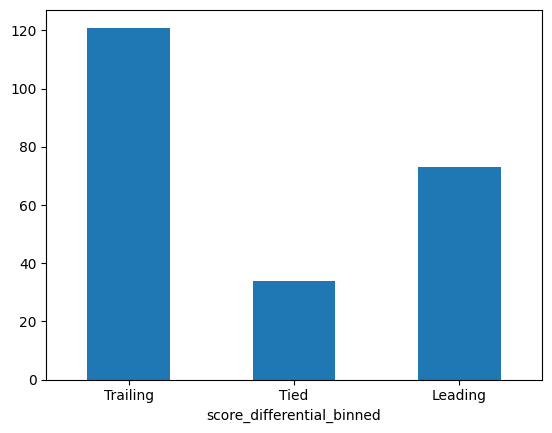

In [64]:
bins = [-28, -0.1, 0.1, 30]
labels = ["Trailing", "Tied", "Leading"]
plays_with_injuries_and_injury_record['score_differential_binned'] = pd.cut(plays_with_injuries_and_injury_record['score_differential'], bins=bins, labels=labels, include_lowest=True)
plays_with_injuries_and_injury_record['score_differential_binned'].value_counts(sort=False).plot(kind="bar", rot=0)

In [47]:
# adding injured and missed time columns as model output
columns_to_check = ['play_id', 'game_id']
play_df["was_injured"] = 0
play_df["missed_time"] = 0
play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

In [85]:
play_df.columns

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success',
       'xyac_fd', 'xpass', 'pass_oe', 'was_injured', 'missed_time', 'date'],
      dtype='object', length=375)

In [86]:
selected_columns = play_df.columns[:5].tolist() + ['was_injured', 'missed_time']
play_df[play_df.was_injured == 1][selected_columns].head()

,play_id,game_id,old_game_id,home_team,away_team,was_injured,missed_time
8,199,2024_01_ARI_BUF,2024090801,BUF,ARI,1,1
29,781,2024_01_ARI_BUF,2024090801,BUF,ARI,1,1
259,2334,2024_01_BAL_KC,2024090500,KC,BAL,1,1
331,4058,2024_01_BAL_KC,2024090500,KC,BAL,1,0
336,4165,2024_01_BAL_KC,2024090500,KC,BAL,1,0
